## Import all the libraries

In [1]:
import numpy as np
import dask
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import time
from dask.diagnostics import ProgressBar
from datetime import date
import json
import os
import warnings
import seawater
import re

warnings.filterwarnings('ignore')


## Parameters

In [5]:
ymin=2010;mmin=1;dmin=1
ymax=2010;mmax=4;dmax=30
# depth of the desired comparison profile in m
depthmin=500
# radius of the circle around the profile location in which we take the modeled profiles, in °  
radius_max=0.25
# period of time around the profile sampling date in which we take the modeled profiles, in days
period=5
# minimum amount of model profiles to be considered to make a significant statistical comparison, for instance in a 1° square and 30-days window we have 2.6 millions modeled profiles, in a 0.5°x10 days 216 000
number_of_model_profiles=100000
# 
debug_plot=False


In [6]:
datemin=datetime.date(ymin,mmin,dmin)
datemax=datetime.date(ymax,mmax,dmax)
jsonfile='txt/MEDWEST60-BLBT02_'+str(datemin)+'-'+str(datemax)+'_'+str(depthmin)+'m_'+str(radius_max)+'x'+str(period)+'d_'+str(number_of_model_profiles)+'.json'

## Read the jsonfile

In [7]:
sourcefile=open(jsonfile,'rU')
infos=json.load(sourcefile)
nb_profilesEN4=len(infos)


## Loop on the number of profiles

In [17]:
    prof=9
    # Process one profile
    list_profiles = infos.keys()
    reference =  str(list(list_profiles)[prof])
    print('Processing profile ', reference)

    # Get all infos from json file
    lat_prof = infos[list(list_profiles)[prof]]['latitude']
    lon_prof = infos[list(list_profiles)[prof]]['longitude']
    date_prof = infos[list(list_profiles)[prof]]['date']
    file_prof = infos[list(list_profiles)[prof]]['file']
    prof_prof = infos[list(list_profiles)[prof]]['profile no']
    i0 = infos[list(list_profiles)[prof]]['i0']
    j0 = infos[list(list_profiles)[prof]]['j0']

    # List of all model files involved
    date_profmin=datetime.date(int(date_prof[0:4]),int(date_prof[5:7]),int(date_prof[8:10]))-datetime.timedelta(days=int(period))
    date_profmax=datetime.date(int(date_prof[0:4]),int(date_prof[5:7]),int(date_prof[8:10]))+datetime.timedelta(days=int(period))
    def date_range(start, end):
        r = (end+datetime.timedelta(days=1)-start).days
        return [start+datetime.timedelta(days=i) for i in range(r)]
    dateList = date_range(date_profmin, date_profmax) 
    dirmod="/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/"
    list_filesmod_T=[]
    list_filesmod_S=[]
    for date in dateList:
        year=date.year
        month=date.month
        day=date.day
        mm="{:02d}".format(month) #month on 2 digits
        dd="{:02d}".format(day) # day on 2 digits
        list_filesmod_T.append(dirmod+'MEDWEST60-BLBT02_y'+str(year)+'m'+str(mm)+'d'+str(dd)+'.1h_gridT.nc')
        list_filesmod_S.append(dirmod+'MEDWEST60-BLBT02_y'+str(year)+'m'+str(mm)+'d'+str(dd)+'.1h_gridS.nc')
    print(list_filesmod_T)  
    
    # Read model files
    dsT=xr.open_mfdataset(list_filesmod_T)
    dsS=xr.open_mfdataset(list_filesmod_S)
    gdpts=np.int(np.round(radius_max*60))

    lonmod=dsT.nav_lon[0,j0-gdpts:j0+gdpts,i0-gdpts:i0+gdpts]
    latmod=dsT.nav_lat[0,j0-gdpts:j0+gdpts,i0-gdpts:i0+gdpts]
    tempmod=dsT.votemper[:,:,j0-gdpts:j0+gdpts,i0-gdpts:i0+gdpts]
    saltmod=dsS.vosaline[:,:,j0-gdpts:j0+gdpts,i0-gdpts:i0+gdpts]
    depthmod=dsT.deptht
    meshfile='/gpfsstore/rech/egi/commun/MEDWEST60/MEDWEST60-I/mesh_mask.nc'
    ds=xr.open_dataset(meshfile)
    maskmod=ds.tmask[0,:,j0-gdpts:j0+gdpts,i0-gdpts:i0+gdpts]
    maskmod0=ds.tmask[0,0,j0-gdpts:j0+gdpts,i0-gdpts:i0+gdpts]

    #Get the depth at every grid point
    d,ly,lx=maskmod.shape
    depthmod2d=np.zeros([lx,ly])
    for j in np.arange(ly):
        for i in np.arange(lx):
            depthmod2d[j,i]=depthmod[np.min(np.where(maskmod[:,j,i].values<1))].values
    
    # Read the profile file
    diren4="/gpfswork/rech/egi/rote001/EN4/"
    tfileEN4=diren4+file_prof
    dsen4=xr.open_dataset(tfileEN4)
    laten4=dsen4['LATITUDE'][prof_prof]
    lonen4=dsen4['LONGITUDE'][prof_prof]
    dayen4=dsen4['JULD'][prof_prof]
    tempen4=dsen4['TEMP'][prof_prof]
    salten4=dsen4['PSAL'][prof_prof]
    presen4=dsen4['PRES_ADJUSTED'][prof_prof]
    depthen4=seawater.dpth(presen4,laten4)

    # Find the last level and reduce the profiles
    indzprof=np.min(np.where(np.isnan(depthen4)==True))
    dmax=depthen4[indzprof-1]
    obsred_dep=np.zeros(int(indzprof))
    obsred_temp=np.zeros(int(indzprof))
    obsred_salt=np.zeros(int(indzprof))
    for z in np.arange(int(indzprof)):
        obsred_dep[int(z)]=depthen4[int(z)]
        obsred_temp[int(z)]=tempen4[int(z)]
        obsred_salt[int(z)]=salten4[int(z)]



Processing profile  Profile_20100114_prof.nc_3
['/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m01d09.1h_gridT.nc', '/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m01d10.1h_gridT.nc', '/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m01d11.1h_gridT.nc', '/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m01d12.1h_gridT.nc', '/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m01d13.1h_gridT.nc', '/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m01d14.1h_gridT.nc', '/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m01d15.1h_gridT.nc', '/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m01d16.1h_gridT.nc', '/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m01d17.1h_gridT.nc', '/gpfsstore/rech

In [18]:
    # Remove the NaN in the profiles
    indtempnan=np.where(np.isnan(obsred_temp)==True)
    if len(indtempnan[0]) > 0:
        obsred_dep = np.delete(obsred_dep, indtempnan[0])    
        obsred_salt = np.delete(obsred_salt, indtempnan[0])    
        obsred_temp = np.delete(obsred_temp, indtempnan[0])    
    indsaltnan=np.where(np.isnan(obsred_salt)==True)
    if len(indsaltnan[0]) > 0:
        obsred_dep = np.delete(obsred_dep, indsaltnan[0])    
        obsred_salt = np.delete(obsred_salt, indsaltnan[0])    
        obsred_temp = np.delete(obsred_temp, indsaltnan[0])    


In [19]:
    # Find the model profiles
    lon_stacked = lonmod.stack(profile=('x', 'y'))
    lat_stacked = latmod.stack(profile=('x', 'y'))
    mask_stacked = maskmod0.stack(profile=('x', 'y'))
    xr_depthmod2d=xr.DataArray(depthmod2d, dims=('y', 'x'))
    depth_stacked = xr_depthmod2d.stack(profile=('x', 'y'))
    
    distance_threshold = radius_max
    square_distance_to_observation = (lon_stacked - lon_prof)**2 + (lat_stacked-lat_prof)**2
    square_distance_to_observation_mask = np.ma.masked_where(mask_stacked==0.,square_distance_to_observation) 
    square_distance_to_observation_sorted = np.sort(square_distance_to_observation_mask)
    nb_profiles_per_timestep=number_of_model_profiles/(24*period*2+24)
    new_threshold=square_distance_to_observation_sorted[int(np.round(nb_profiles_per_timestep)+1)]
    is_closer_to_observation = (square_distance_to_observation < new_threshold) & (depth_stacked > depthmin)

    model_temperature_stacked = tempmod.stack(profile=('x', 'y'))
    model_salinity_stacked = saltmod.stack(profile=('x', 'y'))

    model_temperature_near_observation = model_temperature_stacked.where(is_closer_to_observation,drop=True)
    model_salinity_near_observation = model_salinity_stacked.where(is_closer_to_observation, drop=True)
    lat_near_observation = lat_stacked.where(is_closer_to_observation, drop=True)
    lon_near_observation = lon_stacked.where(is_closer_to_observation, drop=True)
    
    # Compute statistics on the model profiles
    temp_model_mean = np.mean(model_temperature_near_observation,axis=(0,2))
    temp_percentile_10= np.percentile(model_temperature_near_observation,10,axis=(0,2))
    temp_percentile_90= np.percentile(model_temperature_near_observation,90,axis=(0,2))
    salt_model_mean = np.mean(model_salinity_near_observation,axis=(0,2))
    salt_percentile_10= np.percentile(model_salinity_near_observation,10,axis=(0,2))
    salt_percentile_90= np.percentile(model_salinity_near_observation,90,axis=(0,2))
    
    # Interpolate on obs vertical grid
    temp_model_mean_depobs=np.interp(obsred_dep,depthmod,temp_model_mean)
    temp_model_percentile_10_depobs=np.interp(obsred_dep,depthmod,temp_percentile_10)
    temp_model_percentile_90_depobs=np.interp(obsred_dep,depthmod,temp_percentile_90)
    salt_model_mean_depobs=np.interp(obsred_dep,depthmod,salt_model_mean)
    salt_model_percentile_10_depobs=np.interp(obsred_dep,depthmod,salt_percentile_10)
    salt_model_percentile_90_depobs=np.interp(obsred_dep,depthmod,salt_percentile_90)
    


In [60]:
model_temperature_near_observation.shape

(264, 212, 282)

In [62]:
obsred_dep

array([ 14.885993  ,  25.80169868,  35.72457123,  44.65472794,
        55.56885529,  65.49027252,  75.41120911,  85.33168793,
        95.25166321, 105.17116547, 115.09017944, 125.0087204 ,
       134.92677307, 144.84437561, 154.76145935, 164.67808533,
       174.59422302, 184.50990295, 194.42507935, 204.33976746,
       214.25401306, 224.16773987, 234.08103943, 243.99380493,
       253.90615845, 263.81799316, 273.7293396 , 283.64022827,
       293.55062866, 303.46057129, 313.36999512, 323.2789917 ,
       333.18746948, 343.09552002, 353.00305176, 362.91009521,
       372.81668091, 382.72280884, 392.628479  , 409.46694946,
       434.22689819, 458.98394775, 483.73797607, 508.48913574,
       534.22705078, 557.9822998 , 582.72454834, 607.46380615,
       632.20001221, 653.96557617])

In [61]:
temp_model_percentile_10_depobs

array([15.39740581, 15.39472346, 15.39104474, 15.38668852, 15.38136437,
       15.37525706, 15.36904873, 15.36261683, 15.33243747, 15.1060912 ,
       14.73817846, 14.44755925, 14.22131018, 14.04242619, 13.89163937,
       13.76822671, 13.66784271, 13.58662374, 13.52238324, 13.47345806,
       13.43510713, 13.40510038, 13.38138974, 13.36225069, 13.34646342,
       13.33354584, 13.32265877, 13.31306274, 13.30388102, 13.29491117,
       13.28587804, 13.2761835 , 13.26619396, 13.25541301, 13.2461311 ,
       13.23629728, 13.22712963, 13.21811456, 13.20900819, 13.19408857,
       13.17475789, 13.15788848, 13.14332993, 13.12848143, 13.11482132,
        1.05254577,  0.        ,  0.        ,  0.        ,  0.        ])

In [25]:
indz=np.where(obsred_dep>depthmin)
obsred_dep_red=obsred_dep[0:np.min(indz[0])]
print(obsred_dep_red)

[ 14.885993    25.80169868  35.72457123  44.65472794  55.56885529
  65.49027252  75.41120911  85.33168793  95.25166321 105.17116547
 115.09017944 125.0087204  134.92677307 144.84437561 154.76145935
 164.67808533 174.59422302 184.50990295 194.42507935 204.33976746
 214.25401306 224.16773987 234.08103943 243.99380493 253.90615845
 263.81799316 273.7293396  283.64022827 293.55062866 303.46057129
 313.36999512 323.2789917  333.18746948 343.09552002 353.00305176
 362.91009521 372.81668091 382.72280884 392.628479   409.46694946
 434.22689819 458.98394775 483.73797607]


In [26]:
temp_percentile_10[0:np.min(indz[0])]

array([15.40853262, 15.40791655, 15.40621948, 15.40431986, 15.40277786,
       15.40115004, 15.39964304, 15.39867849, 15.39772673, 15.39716721,
       15.396772  , 15.39631977, 15.39546652, 15.39428825, 15.39302444,
       15.39181204, 15.39066229, 15.38872786, 15.3868206 , 15.38506393,
       15.38314934, 15.38065434, 15.37771177, 15.37500925, 15.37198496,
       15.36886854, 15.36570044, 15.36205826, 15.35214128, 15.32156458,
       15.18657961, 14.95873585, 14.73525372, 14.53874741, 14.37182808,
       14.2278573 , 14.09941206, 13.9847311 , 13.88115807, 13.78881359,
       13.70774984, 13.63771315, 13.57768154])

In [35]:
temp_model_mean_depobs

array([15.68097565, 15.67823339, 15.67421769, 15.66962498, 15.66291436,
       15.65510564, 15.64526891, 15.6237074 , 15.54857028, 15.40460403,
       15.18228226, 14.8841285 , 14.58406873, 14.33435257, 14.12976967,
       13.96649232, 13.83547774, 13.72915221, 13.64374615, 13.57528055,
       13.52038953, 13.47658603, 13.44121006, 13.41217796, 13.38833922,
       13.36886185, 13.35229722, 13.33838073, 13.32620387, 13.31517309,
       13.3046975 , 13.29406386, 13.28357788, 13.27196277, 13.261254  ,
       13.25029342, 13.24010002, 13.23051126, 13.22121616, 13.20613419,
       13.18595212, 13.16812235, 13.15268832, 12.70841502, 12.43106678,
       11.66640587, 10.81624344,  9.48055463,  7.93980637,  6.72056752])

In [36]:
temp_model_percentile_10_depobs

array([15.39740581, 15.39472346, 15.39104474, 15.38668852, 15.38136437,
       15.37525706, 15.36904873, 15.36261683, 15.33243747, 15.1060912 ,
       14.73817846, 14.44755925, 14.22131018, 14.04242619, 13.89163937,
       13.76822671, 13.66784271, 13.58662374, 13.52238324, 13.47345806,
       13.43510713, 13.40510038, 13.38138974, 13.36225069, 13.34646342,
       13.33354584, 13.32265877, 13.31306274, 13.30388102, 13.29491117,
       13.28587804, 13.2761835 , 13.26619396, 13.25541301, 13.2461311 ,
       13.23629728, 13.22712963, 13.21811456, 13.20900819, 13.19408857,
       13.17475789, 13.15788848, 13.14332993, 13.12848143, 13.11482132,
        1.05254577,  0.        ,  0.        ,  0.        ,  0.        ])

In [37]:
obsred_dep

array([ 14.885993  ,  25.80169868,  35.72457123,  44.65472794,
        55.56885529,  65.49027252,  75.41120911,  85.33168793,
        95.25166321, 105.17116547, 115.09017944, 125.0087204 ,
       134.92677307, 144.84437561, 154.76145935, 164.67808533,
       174.59422302, 184.50990295, 194.42507935, 204.33976746,
       214.25401306, 224.16773987, 234.08103943, 243.99380493,
       253.90615845, 263.81799316, 273.7293396 , 283.64022827,
       293.55062866, 303.46057129, 313.36999512, 323.2789917 ,
       333.18746948, 343.09552002, 353.00305176, 362.91009521,
       372.81668091, 382.72280884, 392.628479  , 409.46694946,
       434.22689819, 458.98394775, 483.73797607, 508.48913574,
       534.22705078, 557.9822998 , 582.72454834, 607.46380615,
       632.20001221, 653.96557617])

In [41]:
depthmod.values

array([4.80454773e-01, 1.55879164e+00, 2.79421043e+00, 4.18731070e+00,
       5.73867321e+00, 7.44886065e+00, 9.31841755e+00, 1.13478689e+01,
       1.35377216e+01, 1.58884602e+01, 1.84005527e+01, 2.10744438e+01,
       2.39105644e+01, 2.69093151e+01, 3.00710869e+01, 3.33962402e+01,
       3.68851204e+01, 4.05380478e+01, 4.43553276e+01, 4.83372383e+01,
       5.24840355e+01, 5.67959518e+01, 6.12732086e+01, 6.59159927e+01,
       7.07244797e+01, 7.56988144e+01, 8.08391113e+01, 8.61454926e+01,
       9.16180191e+01, 9.72567673e+01, 1.03061752e+02, 1.09033005e+02,
       1.15170502e+02, 1.21474220e+02, 1.27944099e+02, 1.34580063e+02,
       1.41382019e+02, 1.48349823e+02, 1.55483353e+02, 1.62782425e+02,
       1.70246857e+02, 1.77876450e+02, 1.85670959e+02, 1.93630112e+02,
       2.01753662e+02, 2.10041290e+02, 2.18492691e+02, 2.27107513e+02,
       2.35885391e+02, 2.44825958e+02, 2.53928802e+02, 2.63193481e+02,
       2.72619568e+02, 2.82206635e+02, 2.91954132e+02, 3.01861572e+02,
      

In [42]:
temp_percentile_10

array([15.40853262, 15.40791655, 15.40621948, 15.40431986, 15.40277786,
       15.40115004, 15.39964304, 15.39867849, 15.39772673, 15.39716721,
       15.396772  , 15.39631977, 15.39546652, 15.39428825, 15.39302444,
       15.39181204, 15.39066229, 15.38872786, 15.3868206 , 15.38506393,
       15.38314934, 15.38065434, 15.37771177, 15.37500925, 15.37198496,
       15.36886854, 15.36570044, 15.36205826, 15.35214128, 15.32156458,
       15.18657961, 14.95873585, 14.73525372, 14.53874741, 14.37182808,
       14.2278573 , 14.09941206, 13.9847311 , 13.88115807, 13.78881359,
       13.70774984, 13.63771315, 13.57768154, 13.52650709, 13.48436661,
       13.44940825, 13.42071791, 13.39701023, 13.37734804, 13.36070127,
       13.34642792, 13.33424158, 13.32374039, 13.31439657, 13.30532742,
       13.29635143, 13.2872839 , 13.27731113, 13.26690044, 13.25542736,
       13.24540396, 13.23457718, 13.22455406, 13.21439266, 13.20391054,
       13.19396505, 13.18437138, 13.17561979, 13.16710634, 13.15

In [45]:
ind=np.where(temp_percentile_10==0)
print(ind[0])

[ 77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211]


In [46]:
temp_percentile_10[77]

0.0

In [47]:
temp_percentile_90[77]

13.125358867645264

In [49]:
temp_model_mean[77].values

array(11.628672, dtype=float32)

In [51]:
model_temperature_near_observation.shape

(264, 212, 282)

In [53]:
model_temperature_near_observation[0,77,:].values

array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
       13.116647 , 13.121037 , 13.120473 , 13.119684 , 13.122994 ,
        0.       ,  0.       , 13.109489 , 13.112662 , 13.114429 ,
       13.113795 , 13.115534 , 13.117997 , 13.118985 ,  0.       ,
        0.       , 13.107102 , 13.106172 , 13.106108 , 13.109184 ,
       13.110739 , 13.114375 , 13.1166   , 13.117456 , 13.116825 ,
        0.       , 13.117871 , 13.114899 , 13.108356 , 13.104875 ,
       13.10637  , 13.110501 , 13.109641 , 13.110933 , 13.111559 ,
       13.112585 , 13.112851 ,  0.       , 13.116806 ,  0.       ,
        0.       , 13.112588 , 13.107203 , 13.109852 , 13.107611 ,
       13.107154 , 13.109458 , 13.111062 , 13.112394 , 13.112591 ,
       13.135389 , 13.130575 , 13.132115 , 13.129757 ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       , 13.121176 , 13.12104  , 13.117628 ,  0.       ,
        0.       , 13.108997 , 13.1044855, 13.108951 , 13.1073

In [56]:
depth_near_observation = depth_stacked.where(is_closer_to_observation, drop=True)
print(depth_near_observation.values)

[532.6652832  545.78405762 559.04736328 519.69195557 559.04736328
 586.00415039 613.52862549 613.52862549 613.52862549 599.69586182
 506.86480713 532.6652832  586.00415039 627.50146484 655.86376953
 655.86376953 641.61352539 627.50146484 627.50146484 532.6652832
 559.04736328 586.00415039 599.69586182 627.50146484 641.61352539
 641.61352539 655.86376953 655.86376953 655.86376953 670.25140381
 519.69195557 572.4543457  572.4543457  572.4543457  586.00415039
 613.52862549 613.52862549 627.50146484 641.61352539 655.86376953
 684.77539062 699.43481445 545.78405762 572.4543457  559.04736328
 506.86480713 572.4543457  599.69586182 613.52862549 613.52862549
 655.86376953 670.25140381 699.43481445 714.22869873 714.22869873
 572.4543457  599.69586182 613.52862549 599.69586182 559.04736328
 545.78405762 506.86480713 506.86480713 506.86480713 506.86480713
 545.78405762 599.69586182 599.69586182 572.4543457  506.86480713
 559.04736328 586.00415039 613.52862549 627.50146484 641.61352539
 670.251403

In [59]:
depth_near_observation[0].values

array(532.6652832)

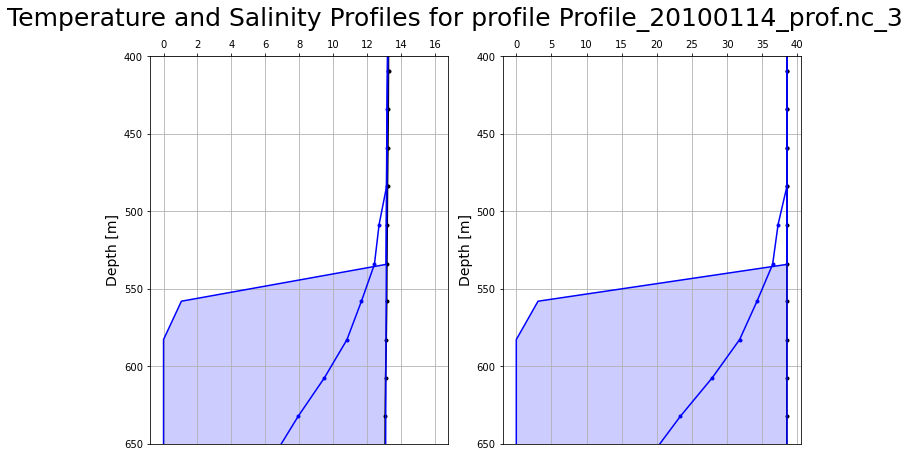

In [31]:
        fig, axs = plt.subplots(1,2, figsize=(10, 6))
        axs = axs.ravel()
        title = 'Temperature and Salinity Profiles for profile '+reference
        plt.suptitle(title,size = 25,y=1.05)
        axs[0].plot(temp_model_mean_depobs,obsred_dep,'b.-', label='temp model')
        axs[0].plot(obsred_temp,obsred_dep,'k.-', label='temp en4')
        axs[0].set_ylabel('Depth [m]', size=14)
        axs[0].set_ylim(650, 400)
        axs[0].grid(True, which='both')
        axs[0].xaxis.tick_top()
        axs[0].xaxis.set_label_position('top') 
        axs[0].plot(temp_model_percentile_10_depobs,obsred_dep,'b-', label='percent10')
        axs[0].plot(temp_model_percentile_90_depobs,obsred_dep,'b-', label='percent90')
        axs[0].fill_betweenx(obsred_dep, temp_model_percentile_10_depobs, x2=temp_model_percentile_90_depobs, alpha=0.2, facecolor='b')

        axs[1].plot(salt_model_mean_depobs,obsred_dep,'b.-', label='salt model')
        axs[1].plot(obsred_salt,obsred_dep,'k.-', label='salt en4')
        axs[1].set_ylabel('Depth [m]', size=14)
        axs[1].set_ylim(650, 400)
        axs[1].grid(True, which='both')
        axs[1].xaxis.tick_top()
        axs[1].xaxis.set_label_position('top') 
        axs[1].plot(salt_model_percentile_10_depobs,obsred_dep,'b-', label='percent10')
        axs[1].plot(salt_model_percentile_90_depobs,obsred_dep,'b-', label='percent90')
        axs[1].fill_betweenx(obsred_dep, salt_model_percentile_10_depobs, x2=salt_model_percentile_90_depobs, alpha=0.2, facecolor='b')
        fig.tight_layout()



In [ ]:
        fig, axs = plt.subplots(1,2, figsize=(10, 6))
        axs = axs.ravel()
        title = 'Temperature and Salinity Profiles for profile '+reference
        plt.suptitle(title,size = 25,y=1.05)
        axs[0].plot(temp_model_mean_depobs[0:np.min(indz[0])],obsred_dep[0:np.min(indz[0])],'b.-', label='temp model')
        axs[0].plot(obsred_temp[0:np.min(indz[0])],obsred_dep[0:np.min(indz[0])],'k.-', label='temp en4')
        axs[0].set_ylabel('Depth [m]', size=14)
        axs[0].set_ylim(depthmin, 0)
        axs[0].grid(True, which='both')
        axs[0].xaxis.tick_top()
        axs[0].xaxis.set_label_position('top') 
        axs[0].plot(temp_model_percentile_10_depobs[0:np.min(indz[0])],obsred_dep[0:np.min(indz[0])],'b-', label='percent10')
        axs[0].plot(temp_model_percentile_90_depobs[0:np.min(indz[0])],obsred_dep[0:np.min(indz[0])],'b-', label='percent90')
        axs[0].fill_betweenx(obsred_dep[0:np.min(indz[0])], temp_model_percentile_10_depobs[0:np.min(indz[0])], x2=temp_model_percentile_90_depobs[0:np.min(indz[0])], alpha=0.2, facecolor='b')

        axs[1].plot(salt_model_mean_depobs[0:np.min(indz[0])],obsred_dep[0:np.min(indz[0])],'b.-', label='salt model')
        axs[1].plot(obsred_salt[0:np.min(indz[0])],obsred_dep[0:np.min(indz[0])],'k.-', label='salt en4')
        axs[1].set_ylabel('Depth [m]', size=14)
        axs[1].set_ylim(depthmin, 0)
        axs[1].grid(True, which='both')
        axs[1].xaxis.tick_top()
        axs[1].xaxis.set_label_position('top') 
        axs[1].plot(salt_model_percentile_10_depobs[0:np.min(indz[0])],obsred_dep[0:np.min(indz[0])],'b-', label='percent10')
        axs[1].plot(salt_model_percentile_90_depobs[0:np.min(indz[0])],obsred_dep[0:np.min(indz[0])],'b-', label='percent90')
        axs[1].fill_betweenx(obsred_dep[0:np.min(indz[0])], salt_model_percentile_10_depobs[0:np.min(indz[0])], x2=salt_model_percentile_90_depobs[0:np.min(indz[0])], alpha=0.2, facecolor='b')
        fig.tight_layout()



In [ ]:
    # Write netcdf file
    match=re.search(r'([\w.-]+).nc([\w.-]+)', reference)
    debut_ref=match.group(1)
    fin_ref=match.group(2)
    dirname=diren4+'profiles_files/MEDWEST60-BLBT02/'
    if not os.path.exists(dirname):
        os.makedirs(dirname)    
  
    outname=dirname+str(debut_ref)+str(fin_ref)+'_MEDWEST60-BLBT02_TS.nc'
    print('output file is '+outname)
    dsout=Dataset(outname,'w')

    today=date.today()
    dsout.description = "This file contains one profile of temperature and salinity from EN4 dataset and the mean and 10 and 90 percentile of NATL60-CJM165 data within a 0.25deg circle around the location of the profile and 15 days before and after it has been sampled. This file has been created "+str(today.day)+"/"+str(today.month)+"/"+str(today.year)

    depth=dsout.createDimension('depth',len(obsred_dep))
    x=dsout.createDimension('x',1)
    y=dsout.createDimension('y',1)
    
    lat = dsout.createVariable('latitude_profileEN4', 'f8', ('y','x'))
    lat.standart_name="latitude_profileEN4"
    lat.long_name = "Latitude of selected EN4 profile" 
    lat.units = "degrees_north"

    lon = dsout.createVariable('longitude_profileEN4', 'f8', ('y','x'))
    lon.standart_name="longitude_profileEN4"
    lon.long_name = "Longitude of selected EN4 profile" 
    lon.units = "degrees_east"

    time = dsout.createVariable('time_profileEN4', 'f8', ('y','x'))
    time.standart_name="time_profileEN4"
    time.timeg_name = "Time in seconds from 1-1-1958 of selected EN4 profile" 
    time.units = "s"

    depth_en4 = dsout.createVariable('depth_en4', 'f8', ('depth'),fill_value=0.)
    depth_en4.units = "m" 
    depth_en4.valid_min = 0.
    depth_en4.valid_max = 8000.
    depth_en4.long_name = "Depth" 

    temp_en4 = dsout.createVariable('temp_profileEN4', 'f8', ('depth'),fill_value=0.)
    temp_en4.units = "degC" 
    temp_en4.valid_min = -10.
    temp_en4.valid_max = 40.
    temp_en4.long_name = "Temperature profile of the selected EN4 profile" 

    salt_en4 = dsout.createVariable('salt_profileEN4', 'f8', ('depth'),fill_value=0.)
    salt_en4.units = "PSU" 
    salt_en4.valid_min = 20.
    salt_en4.valid_max = 40.
    salt_en4.long_name = "Salinity profile of the selected EN4 profile" 

    mean_temp_model = dsout.createVariable('mean_temp_model', 'f8', ('depth'),fill_value=0.)
    mean_temp_model.units = "degC" 
    mean_temp_model.valid_min = -10.
    mean_temp_model.valid_max = 40.
    mean_temp_model.long_name = "Mean Temperature profile of the model" 

    mean_salt_model = dsout.createVariable('mean_salt_model', 'f8', ('depth'),fill_value=0.)
    mean_salt_model.units = "PSU" 
    mean_salt_model.valid_min = 20.
    mean_salt_model.valid_max = 40.
    mean_salt_model.long_name = "Mean Salinity profile of the model" 

    percent10_temp_model = dsout.createVariable('percent10_temp_model', 'f8', ('depth'),fill_value=0.)
    percent10_temp_model.units = "degC" 
    percent10_temp_model.valid_min = -10.
    percent10_temp_model.valid_max = 40.
    percent10_temp_model.long_name = "Percent 10 Temperature profile of the model" 

    percent10_salt_model = dsout.createVariable('percent10_salt_model', 'f8', ('depth'),fill_value=0.)
    percent10_salt_model.units = "PSU" 
    percent10_salt_model.valid_min = 20.
    percent10_salt_model.valid_max = 40.
    percent10_salt_model.long_name = "Percent 10 Salinity profile of the model" 

    percent90_temp_model = dsout.createVariable('percent90_temp_model', 'f8', ('depth'),fill_value=0.)
    percent90_temp_model.units = "degC" 
    percent90_temp_model.valid_min = -90.
    percent90_temp_model.valid_max = 40.
    percent90_temp_model.long_name = "Percent 90 Temperature profile of the model" 

    percent90_salt_model = dsout.createVariable('percent90_salt_model', 'f8', ('depth'),fill_value=0.)
    percent90_salt_model.units = "PSU" 
    percent90_salt_model.valid_min = 20.
    percent90_salt_model.valid_max = 40.
    percent90_salt_model.long_name = "Percent 90 Salinity profile of the model" 


    lat[:]=lat_prof
    lon[:]=lon_prof
    time[:]=(datetime.datetime(int(date_prof[0:4]),int(date_prof[5:7]),int(date_prof[8:10]))-datetime.datetime(1958,1,1,0,0)).total_seconds()
    depth_en4[:]=obsred_dep
    temp_en4[:]=obsred_temp
    salt_en4[:]=obsred_salt
    mean_temp_model[:]=temp_model_mean_depobs
    mean_salt_model[:]=salt_model_mean_depobs
    percent10_temp_model[:]=temp_model_percentile_10_depobs
    percent10_salt_model[:]=salt_model_percentile_10_depobs
    percent90_temp_model[:]=temp_model_percentile_90_depobs
    percent90_salt_model[:]=salt_model_percentile_90_depobs
    dsout.close()  # close the new file
    

In [ ]:
print("Nb de profiles : "+str(nb_profilesEN4))
print(time.strftime('%d/%m/%y %H:%M',time.localtime()))

for prof in range(nb_profilesEN4):
    list_profiles = infos.keys()
    reference =  str(list(list_profiles)[prof])
    match=re.search(r'([\w.-]+).nc([\w.-]+)', reference)
    debut_ref=match.group(1)
    fin_ref=match.group(2)
    diren4="/gpfswork/rech/egi/rote001/EN4/"
    dirname=diren4+'profiles_files/MEDWEST60-BLBT02/'
    outname=dirname+str(debut_ref)+str(fin_ref)+'_MEDWEST60-BLBT02_TS.nc'
    if not os.path.exists(outname):
        process_one_profile(prof)

print(time.strftime('%d/%m/%y %H:%M',time.localtime()))
